In [1]:
import random
import numpy as np
import scipy.stats
import pandas as pd
from sklearn.utils import shuffle
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Helper Functions

In [94]:
#-------- Functions --------------

def get_face(card):
        
        if 'Ace' in card:
            face = 'Ace'
            
        elif 'Jack' in card:
            face = 'Jack'
            
        elif 'Queen' in card:
            face = 'Queen'
            
        elif 'King' in card:
            face = 'King'
            
        else:
            face = re.search('\d{1,2}',card)[0]
            
        return face
    


def get_value(card):
        
        if 'Ace' in card:
            value = 11
            
        elif 'Jack' in card:
            value = 10
            
        elif 'Queen' in card:
            value = 10
            
        elif 'King' in card:
            value = 10
            
        else:
            value = int(re.search('\d{1,2}',card)[0])
            
        return value
    
    

def shuffle_deck(number_decks = 6):
#function to shuffle together k number of decks and return a list of cards

#     print('\nDown to {} cards in shoe'.format(len(shoe)))
#     print('================== Shuffling {} decks =========================\n'.format(number_decks))
    
    #load shoe 
    cards = []
   
    for deck in range(1,number_decks+1):
        for n in range(1,14):
            
            if n == 1:
                n_str = 'Ace'
                
            elif n == 11:
                n_str = 'Jack'
                
            elif n == 12:
                n_str = 'Queen'
                
            elif n == 13:
                n_str = 'King'
            
            else:
                n_str = str(n)
                
            for suit in ['Clubs','Diamonds','Spades','Hearts']:
                cards.append(n_str + ' ' + suit)

    cards = shuffle(cards)
    return cards



def play_hand(run_with_model, model, results_lists, player, player_total, hand, soft_hand, sub_hand, 
              splittable, dealer_showing, dealer_total, num_tens, num_lows, split_aces, bet, print_on):

    #function that plays out a players hand until they choose to stay or they bust
    #for each card played, results are logged
    #returns results_lists, which is a list of lists
    
    #unpack results lists
    results_player = results_lists[0]
    results_player_start_total = results_lists[1]
    results_player_end_total = results_lists[2]
    results_dealer_showing = results_lists[3]
    results_action = results_lists[4]
    results_dealer_total = results_lists[5]
    results_hand = results_lists[6]
    results_soft_hand = results_lists[7]
    results_sub_hand = results_lists[8]
    results_splittable = results_lists[9]
    results_bet = results_lists[10]
        
    on_first_move = True
    doubleable = 0
    action = ''
   
    if player_total == 21:
        action = 'blackjack'
        soft_hand = 0
        
    #play hand by hitting or staying 
    player_start_total = player_total
    
    while player_total < 21:
        
        
        doubleable = 0
        if on_first_move == True:
            if (player_total in (9,10,11)) | (soft_hand == 1):
                doubleable = 1
                 
        if player_total > 11:
            
            #decide whether to stay or hit
            go = random.randint(0,1)
            if run_with_model == True:
                model_recommendation= get_recommended_move(model, bet, player_total, soft_hand, dealer_showing, 
                                               0, doubleable)
             
                if model_recommendation == 'stay':
                    go = 1
                else:
                    go = 0
                
                
            if go == 1:
                action = 'stay'
                player_end_total = player_total
            
                if print_on == True:
                    print('Player Total:{}   Soft:{}'.format(player_total,soft_hand))
                    print('Stay')
                
                break
            
        if action != 'stay':
            
            #if did not stay in above step, hit and log results
            action = 'hit'
            
            #If it's the first move, decide whether to double down and take one card only
            if (doubleable == 1):
                
                go = random.randint(0,1)
                if run_with_model == True:
                    model_recommendation= get_recommended_move(model, bet, player_total, soft_hand, dealer_showing, 
                                               0, doubleable)
                    if model_recommendation == 'double down':
                        go = 1
                    else:
                        go = 0                    
                
                if go ==1:
                    action = 'double_down'
              
                       
            new_card = shoe.pop()
            v = get_value(new_card)
            
            if v in (10,11):
                num_tens += 1
            
            if v in (2,3,4,5,6):
                num_lows += 1
                
            start_soft_hand = soft_hand
            
            if print_on == True:
                print('Player Total:{}   Soft:{}'.format(player_total,soft_hand))
                if action == 'double_down':
                    print('Double Down' + ': ' + new_card)              
                else:
                    print('Hit' + ': ' + new_card)
                
            #Determine value of ace and whether the hand is soft
            if v == 11 and player_total + 11 > 21:
                v = 1

            if v == 11 and player_total + 11 < 21:
                soft_hand = 1

            if v == 11 and player_total + 11 == 21:
                soft_hand = 0

            player_start_total = player_total
            player_total = player_total + v

            #If hit pushed above 21 and hand is soft, roll back the ace to 1
            if player_total > 21 and soft_hand == 1:
                player_total = player_total - 10
                soft_hand = 0

            results_player.append(player)
            results_player_start_total.append(player_start_total)
            results_player_end_total.append(player_total)
            results_dealer_showing.append(dealer_showing)
            results_action.append(action)
            results_dealer_total.append(dealer_total)
            results_hand.append(hand)
            results_soft_hand.append(start_soft_hand)
            results_sub_hand.append(sub_hand)
            results_splittable.append(splittable)
            results_bet.append(bet)
            
            
            #if double down or split aces, exit the loop.  No more cards to draw.
            if action == 'double_down' or split_aces == True:
                break
             
            on_first_move = False
            
                   
    #write the stay line if there was one
    if action in ('stay','blackjack'):
        results_player.append(player)
        results_player_start_total.append(player_total)
        results_player_end_total.append(player_total)
        results_dealer_showing.append(dealer_showing)
        results_action.append(action)
        results_dealer_total.append(dealer_total)
        results_hand.append(hand)
        results_soft_hand.append(soft_hand)
        results_sub_hand.append(sub_hand)
        results_splittable.append(splittable)
        results_bet.append(bet)

    if print_on == True:      
        print('Final Player Total:{} '.format(player_total))
        if player_total > 21:
            print('Bust')   
            
            
    #repack results_lists
    results_lists[0] = results_player
    results_lists[1] = results_player_start_total 
    results_lists[2] = results_player_end_total 
    results_lists[3] = results_dealer_showing 
    results_lists[4] = results_action 
    results_lists[5] = results_dealer_total  
    results_lists[6] = results_hand 
    results_lists[7] = results_soft_hand 
    results_lists[8] = results_sub_hand 
    results_lists[9] = results_splittable
    results_lists[10] = results_bet


    return results_lists, num_tens, num_lows


def log_split(results_lists, player, player_total, hand, soft_hand, sub_hand, 
              splittable, dealer_showing, dealer_total, bet):
    
    #unpack results lists
    results_player = results_lists[0]
    results_player_start_total = results_lists[1]
    results_player_end_total = results_lists[2]
    results_dealer_showing = results_lists[3]
    results_action = results_lists[4]
    results_dealer_total = results_lists[5]
    results_hand = results_lists[6]
    results_soft_hand = results_lists[7]
    results_sub_hand = results_lists[8]
    results_splittable = results_lists[9]
    results_bet = results_lists[10]
    
    results_player.append(player)
    results_player_start_total.append(player_total)
    results_player_end_total.append(player_total)
    results_dealer_showing.append(dealer_showing)
    results_action.append('split')
    results_dealer_total.append(dealer_total)
    results_hand.append(hand)
    results_soft_hand.append(soft_hand)
    results_sub_hand.append(sub_hand)
    results_splittable.append(splittable)
    results_bet.append(bet)
    
    #repack results_lists
    results_lists[0] = results_player
    results_lists[1] = results_player_start_total 
    results_lists[2] = results_player_end_total 
    results_lists[3] = results_dealer_showing 
    results_lists[4] = results_action 
    results_lists[5] = results_dealer_total  
    results_lists[6] = results_hand 
    results_lists[7] = results_soft_hand 
    results_lists[8] = results_sub_hand
    results_lists[9] = results_splittable
    results_lists[10] = results_bet
    
    return results_lists


def get_winnings(row):
    
    #Takes a row from the dataframe and returns the winnings based on the player and dealers end total
    
    bet = row.bet
    
    if row.action == 'double_down':
        multiplier = 2
    else:
        multiplier = 1
    
    if row.action == 'blackjack':
        return 1.5 * bet
        
    if row.player_final_total > 21:
        return -1 * multiplier * bet
    
    elif row.dealer_end_total > 21:
        return 1 * multiplier * bet
    
    elif row.player_final_total > row.dealer_end_total:
        return 1 * multiplier * bet
    
    elif row.player_final_total == row.dealer_end_total:
        return 0 * multiplier * bet
    
    elif row.player_final_total < row.dealer_end_total:
        return -1 * multiplier * bet
    

    
def get_recommended_move(model, bet, player_total, soft_hand, dealer_showing, splittable, doubleable):
    
    eva_split = -99999999
    eva_double = -99999999
          
    #player_start	soft_hand	dealer_showing	double_down	hit	split
    scenario_hit = np.array([player_total, soft_hand, dealer_showing, 0, 1, 0]).reshape(1,-1)
    scenario_stay = np.array([player_total, soft_hand, dealer_showing, 0, 0, 0]).reshape(1,-1)
    
    #get prob of winning from model
    prob_win_hit = model.predict(scenario_hit)[0]
    prob_win_stay = model.predict(scenario_stay)[0]
 
    
    #calculate expected value
    eva_hit = round(prob_win_hit/10 * bet,2)
    eva_stay = round(prob_win_stay/10 * bet,2)          
          
    if splittable == 1:
        scenario_split = np.array([player_total, soft_hand, dealer_showing, 0, 0, 1]).reshape(1,-1) 
        prob_win_split = model.predict(scenario_split)[0]
        eva_split = round(prob_win_split/10 * bet,2)
    
    if doubleable == 1:     
        scenario_double = np.array([player_total, soft_hand, dealer_showing, 1, 1, 0]).reshape(1,-1)
        prob_win_double = model.predict(scenario_double)[0]
        eva_double = round(prob_win_double/10 * bet,2)

          
    max_eva = max(eva_hit, eva_stay, eva_split, eva_double)
    if max_eva == eva_hit:
          recommendation = 'hit'
    
    elif max_eva == eva_stay:
          recommendation = 'stay'
          
    elif max_eva == eva_split:
          recommendation = 'split'
    
    elif max_eva == eva_double:
          recommendation = 'double down'
          
 #      print('Model recommends to {}\n'.format(recommendation))
#     print('Expected Winnings if Hit: ${}'.format(eva_hit))
#     print('Expected Winnings if Stay: ${}'.format(eva_stay))
    
#     if splittable == 1:
#         print('Expected Winnings if Split: ${}'.format(eva_split))
          
#     if doubleable == 1:
#         print('Expected Winnings if Double: ${}'.format(eva_double))

    return recommendation




# Generate Training Data - by Running Simulation

In [254]:
%%time

#-------- Game Variables -----------
print_on = False
run_with_model = True
num_players = 6
num_hands = 2000
num_decks = 6
reshuffle_when_down_to = .25
base_bet = 10
run_with_variable_betting = True
increase_bet_to = 50
count_threshold = 12


#Initialize Lists
results_lists = [ [], [], [], [], [], [], [], [], [], [], []]
card_counting_player = []
card_counting_hand = []
card_counting_num_tens = []
card_counting_num_lows = []
card_counting_shoe_played = []


#shuffle deck
shoe = shuffle_deck(num_decks)
starting_shoe_len = len(shoe)
num_tens = 0
num_lows = 0

for hand in range(1,num_hands+1):
    
    if hand % 50000 == 0:
        print('Simulating Round {}'.format(hand))
    

    if len(shoe) <= num_decks*52*reshuffle_when_down_to:
        shoe = shuffle_deck(num_decks)
        num_tens = 0
        num_lows = 0
        dealer_num_tens = 0
        dealer_num_lows = 0
        starting_shoe_len = len(shoe)
        if print_on == True:
            print('******* DECK SHUFFLED ******')
        
    #----------Deal 2 cards to each player and the dealer ------------------
    cards_dealt = []
    players = []
    for player in range (num_players,-1,-1):

        for n_card in range (0,2):
            card = shoe.pop()
            value = get_value(card)
            cards_dealt.append([player,card,value])

   #---------- Dealer takes his turn first (the Players won't see this) --------------------  

    #Calculate What dealer is showing   
    dealer_card1 = cards_dealt[len(cards_dealt)-1][2]
    dealer_card2 = cards_dealt[len(cards_dealt)-2][2]
    dealer_showing = dealer_card1
    
    dealer_num_tens = 0
    dealer_num_lows = 0
    if dealer_card1 in (10,11):
        dealer_num_tens += 1   
    if dealer_card2 in (10,11):
        dealer_num_tens += 1
    if dealer_card1 in (2,3,4,5,6):
        dealer_num_lows += 1
    if dealer_card2 in (2,3,4,5,6):
        dealer_num_lows += 1    
    
    if print_on == True:
        print('\nDealer')
        print('---------------------')
        print(cards_dealt[len(cards_dealt)-1][1])
        print(cards_dealt[len(cards_dealt)-2][1])  
        
    #Check Dealer Aces
    #If both dealers cards are aces, set one to 1
    if dealer_card1 == 11 and dealer_card2 == 11:
        dealer_card1 = 1
        
    #Determine if dealer has an ace
    if dealer_card1 == 11 or dealer_card2 == 11:
        dealer_soft_hand = True
    else:
        dealer_soft_hand = False
      
    dealer_total = dealer_card1 + dealer_card2
    
    while dealer_total < 17:

        if dealer_total == 17 and dealer_soft_hand == False:
            do_nothing = True
            break

        else:

            new_card = shoe.pop()
            v = get_value(new_card)

            if v in (10,11):
                dealer_num_tens += 1
            if v in (2,3,4,5,6):
                dealer_num_lows += 1
        
            if v == 11 and dealer_total + 11 > 21:
                dealer_soft_hand = 0
                v = 1

            if v == 11 and dealer_total + 11 < 21:
                dealer_soft_hand = 1

            if v == 11 and dealer_total + 11 == 21:
                dealer_soft_hand = 0
              
            dealer_total = dealer_total + v
            
            #If dealer has a soft hand and busted, roll back ace to 1
            if dealer_total > 21 and dealer_soft_hand == 1:
                dealer_total = dealer_total - 10
                dealer_soft_hand = 0
            
            if print_on == True:
                print('Hit: ' + new_card)
    
    if print_on == True:
        print('Dealer Total: ' + str(dealer_total))
    
    

    #---------- Each player plays their turn:  hits or stays --------------------
    prior_player = -1
    player_total = 0    

    for card in range (0,len(cards_dealt)-2):
        player = cards_dealt[card][0]
        
        if player != prior_player:
            #Update Card_Counting_Lists for Hand and Player just completed
            card_counting_player.append(player)
            card_counting_hand.append(hand)
            card_counting_num_tens.append(num_tens)
            card_counting_num_lows.append(num_lows)
            a = (starting_shoe_len - len(shoe)) / starting_shoe_len
            card_counting_shoe_played.append(a)
            
        else:
            #We are ready to play hand.
                  
            bet = base_bet
            if run_with_variable_betting == True:
                #set bet based on card count
                current_count = num_lows - num_tens
                if current_count >= count_threshold:
                    bet = increase_bet_to

            card2_value = cards_dealt[card][2]
            card2_face = cards_dealt[card][1]
            card2_facevalue = get_face(cards_dealt[card][1])
            card1_value = cards_dealt[card-1][2]
            card1_face = cards_dealt[card-1][1] 
            card1_facevalue = get_face(cards_dealt[card-1][1])
            
            split_aces = False
            
            #update num_tens counter
            if card1_value in (10,11):
                num_tens += 1
            
            if card2_value in (10,11):
                num_tens += 1

            if card1_value in (2,3,4,5,6):
                num_lows += 1
            
            if card2_value in (2,3,4,5,6):
                num_lows += 1
                
            #If both cards are same value, mark as splittable
            if card1_facevalue == card2_facevalue:
                splittable = 1
            else:
                splittable = 0
            
            #If both cards are aces, set values of one to 1
            if (card1_value == 11) & (card2_value == 11):
                card1_value = 1
                
            
            #check to see if Ace in either of the original 2 cards dealt.  If so label as soft hand.
            if (card1_value == 11) | (card2_value == 11):
                soft_hand = 1  
            else:
                soft_hand = 0
                
            player_total = card1_value + card2_value
            
            if player_total in (9,10,11):
                doubleable = 1
            else:
                doubleable = 0
                
            if print_on == True:
                print('\nPlayer {} Hand {}'.format(player,hand))
                print('----------------------')
                print(card1_face)
                print(card2_face)
                     
            if splittable == 1:
                
                go = random.randint(0,1)
                if run_with_model == True:
                    model_recommendation= get_recommended_move(model, bet, player_total, soft_hand, dealer_showing, 
                                                           splittable, doubleable)
                    if model_recommendation == 'split':
                        go = 1
                    else:
                        go = 0
                

                if go == 1:
                    
                    #split cards and play both hands
                    results_lists = log_split(results_lists, player, player_total, hand, soft_hand, 0, splittable,
                                             dealer_showing, dealer_total, bet)

                    #if splitting aces, set values of both to 11
                    if card1_facevalue == 'Ace' and card2_facevalue == 'Ace':
                        card1_value = 11
                        card2_value = 11
                        split_aces = True

                    
                    #play hand 1 of split
                    if print_on == True:
                        print('Split')
                        print('Playing Hand 1')
                        print(card1_face)
                    hand1_player_total = card1_value
                    results_lists, num_tens, num_lows = play_hand(run_with_model, model, results_lists, player, 
                                                                  hand1_player_total, hand, 
                                              soft_hand, 1, 0,
                                             dealer_showing, dealer_total, num_tens, num_lows, split_aces, 
                                                                  bet, print_on)

                    #play hand 2 of split
                    if print_on == True:
                        print('Playing Hand 2')
                        print(card2_face)
                    hand2_player_total = card2_value
                    results_lists, num_tens, num_lows = play_hand(run_with_model, model, results_lists, player, 
                                                                  hand2_player_total, 
                                                        hand, soft_hand, 2, 0,
                                                         dealer_showing, dealer_total, num_tens, num_lows, 
                                                                  split_aces, bet, print_on)
                
                else:
                    #play hand without splitting even though splittable
                    results_lists, num_tens, num_lows = play_hand(run_with_model, model, results_lists, player, 
                                                                  player_total, hand, 
                                              soft_hand, 0, splittable,
                                             dealer_showing, dealer_total, num_tens, num_lows, split_aces, 
                                                                  bet, print_on)
            
            else:    
                #play hand without splitting
                results_lists, num_tens, num_lows = play_hand(run_with_model, model, results_lists, player, 
                                                              player_total, hand, 
                                          soft_hand, 0, splittable,
                                         dealer_showing, dealer_total, num_tens, num_lows, split_aces, 
                                                              bet, print_on)
            
  

        prior_player = player
        soft_hand = 0
        

        
        
    #Update num tens now that we've seen the dealers cards
    num_tens = num_tens + dealer_num_tens 
    num_lows = num_lows + dealer_num_lows

    if print_on == True:
        print('***************** Total Count of Tens/Aces {}'.format(num_tens))
        print('***************** Total Count of Lows {}'.format(num_lows))
        print('***************** Total Count = {}'.format(num_tens - num_lows))

 #unpack results lists
results_player = results_lists[0]
results_player_start_total = results_lists[1]
results_player_end_total = results_lists[2]
results_dealer_showing = results_lists[3]
results_action = results_lists[4]
results_dealer_total = results_lists[5]
results_hand = results_lists[6]
results_soft_hand = results_lists[7]
results_sub_hand = results_lists[8]
results_splittable = results_lists[9]
results_bet = results_lists[10]

# for list in results_lists:
#      print(len(list))

# print(len(list_dealer_total))
# print(len(list_dealer_showing))
# print(len(list_dealer_hand))


results = pd.DataFrame({'hand': results_hand, 'sub_hand': results_sub_hand, 'player': results_player,
                       'player_start': results_player_start_total, 'action': results_action,
                       'player_end_total': results_player_end_total, 
                        'soft_hand': results_soft_hand, 'splittable': results_splittable,
                        'dealer_showing' : results_dealer_showing, 'dealer_end_total' : results_dealer_total,
                        'bet' : results_bet
                       })


card_counting = pd.DataFrame({'hand':card_counting_hand, 'player': card_counting_player, 
                              'num_highs': card_counting_num_tens,
                             'num_lows': card_counting_num_lows,
                             'shoe_played' : card_counting_shoe_played})

card_counting['total_count'] = card_counting.num_lows - card_counting.num_highs


#Update Dealer Results and Outcome
print('Calculating Outcomes')
hand_results = pd.DataFrame(results.groupby(by = ['hand','sub_hand','player'])['player_end_total'].last())
hand_results.columns = ['player_final_total']
results = pd.merge(results, hand_results, left_on = ['hand','sub_hand','player'],  
                            right_index=True, how='left')   


results['winnings'] = results.apply(lambda row: get_winnings(row), axis=1)


#Update Split Results
print('Calculating Outcomes for hands that were split')
split_results = pd.DataFrame(results[results.sub_hand != 0].
                             groupby(by = ['hand','sub_hand','player'])['winnings'].last())
split_results = pd.DataFrame(split_results.groupby(by = ['hand','player'])['winnings'].sum())
split_results.columns = ['split_results']
results = pd.merge(results, split_results, how='left', left_on=['hand','player'], right_index=True)
results.at[results.action == 'split','winnings'] = results.split_results
results.drop(columns=['split_results'], axis=1, inplace=True)

#Label results
results['win'] = np.where(results.winnings >= 0, 'win', 'lose')

#Get Outcomes Only
outcomes = results.drop_duplicates(subset = ['hand','player'], keep='first')[['hand','player','action',
                                                    'player_start','dealer_showing',
                                                    'player_end_total','dealer_end_total','bet','winnings','win']]

outcomes['win'] = np.where(outcomes.winnings == 0, 'push', outcomes.win)

outcomes = pd.merge(outcomes, card_counting[['hand','player','total_count']], on=['hand','player'], how='left')



#-------- Filter the data for training purposes ----------
#Remove scenarios that do not require a decision
results_filtered = results.copy()
results_filtered = results_filtered[(results_filtered.player_start >= 9) | 
                                    (results_filtered.splittable == 1) | 
                                    (results_filtered.soft_hand ==1) 
                                   ]


results_filtered = results_filtered[results_filtered.action != 'blackjack']

#Remove the ties
#results_filtered = results_filtered[results_filtered.winnings != 0]

print('Simulation Complete')
print('{} rounds simulated totalling {} hands.\n'.format(num_hands, num_hands*(num_players+1)))


#---- Save Outcome Data into memory ----
if run_with_model == False:
    random_outcomes = outcomes.copy()
    random_results = results.copy()
    random_results_filtered = results_filtered.copy()
    random_card_counting = card_counting.copy()
else:
    if run_with_variable_betting == False:
        trained_outcomes = outcomes.copy()
        trained_results = results.copy()
        trained_card_counting = card_counting.copy()
    elif run_with_variable_betting == True:
        counting_outcomes = outcomes.copy() 
        counting_results = results.copy()
        counting_card_counting = card_counting.copy()

Calculating Outcomes
Calculating Outcomes for hands that were split
Simulation Complete
2000 rounds simulated totalling 14000 hands.

CPU times: user 1min 4s, sys: 487 ms, total: 1min 4s
Wall time: 1min 6s


# Run Models - Using Training Data Generated above

In [50]:
#Seperate into Train and Test Set 

from sklearn.model_selection import train_test_split
x_train = results_filtered.copy()
print(x_train.shape)

dummies = pd.get_dummies(x_train.action)
x_train = pd.concat([x_train, dummies], axis=1)
x_train['hit'] = np.where(x_train.double_down == 1, 1, x_train.hit)

y_train = x_train.winnings

x_train.drop(columns=['splittable', 'sub_hand', 'player_final_total', 'player','hand','player_end_total','dealer_end_total', 'action', 
                      'win','winnings','stay', 'bet'], inplace=True)

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2349544, 14)
(1879635, 6)
(1879635,)
(469909, 6)
(469909,)


#### Model 1 - Random Forest Regression

Training Score 0.14836519048774766
Test Score 0.1471706742351231
CPU times: user 1min 14s, sys: 950 ms, total: 1min 15s
Wall time: 1min 16s


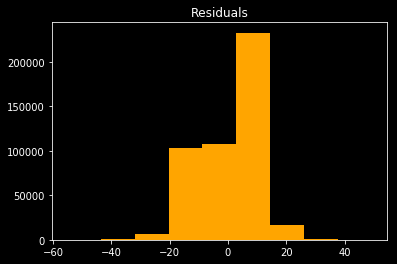

In [51]:
%%time

#Model to predict winnings based on features below
#player_start	soft_hand	dealer_showing	double_down	hit	split

from sklearn import ensemble

rfc = ensemble.RandomForestRegressor(n_estimators=50)
model = rfc.fit(x_train, y_train)

print('Training Score {}'.format(model.score(x_train, y_train)))
print('Test Score {}'.format(model.score(x_test, y_test)))

y_pred = model.predict(x_test)

plt.style.use('dark_background')

residuals = y_pred - y_test
plt.hist(residuals, color='orange', bins=9)
plt.title('Residuals')

Adjusted Test Score 0.7421211018135201


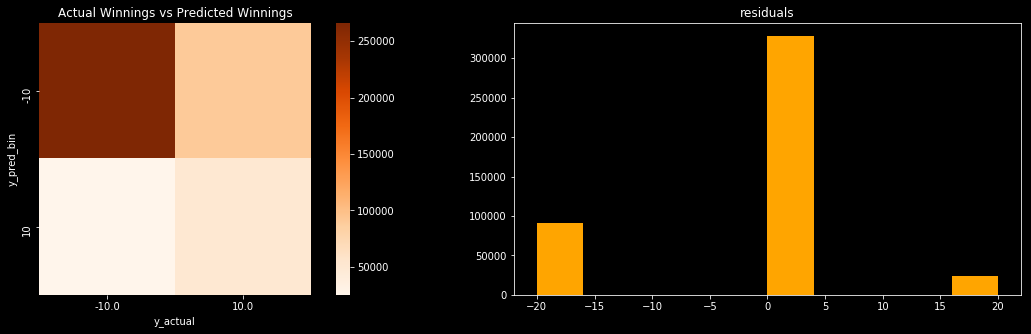

In [52]:
#----  View the accuracy in more detail ----

score_df = x_test.copy()
score_df['y_pred'] = y_pred
score_df['y_actual'] = y_test

score_df['y_actual'] = np.where(score_df.y_actual > 10, 10, score_df.y_actual)
score_df['y_actual'] = np.where(score_df.y_actual < -10, -10, score_df.y_actual)

# score_df['y_pred_bin'] = pd.cut(score_df.y_pred, [-50, -10.01, -3.01, 3.01, 10.01, 50], 
#                                labels=[-20,-10,0,10,20])


score_df = score_df[score_df.y_actual != 0]

score_df['y_pred_bin'] = pd.cut(score_df.y_pred, [-50, 0,  50], 
                               labels=[-10,10])

score_df.y_pred_bin = pd.to_numeric(score_df.y_pred_bin)



a =  score_df['y_pred_bin'] - score_df['y_actual']


df_crosstab = pd.crosstab(score_df.y_pred_bin, score_df.y_actual)

f, axes = plt.subplots(1, 2, sharey=False, sharex=False , figsize=(20,5))

plt.subplot(121)
sns.heatmap(df_crosstab, robust=True, square=True, cmap="Oranges")
plt.title('Actual Winnings vs Predicted Winnings')

plt.subplot(122)
plt.hist(a, color='orange')
plt.title('residuals')


from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

accuracy = accuracy_score(score_df.y_actual, score_df.y_pred_bin)
print('Adjusted Test Score {}'.format(accuracy))

#### Model 2 - Neural Network Regression

Training Score 0.14568913414611906
Test Score 0.14766957823546134


(array([2.08000e+02, 6.62000e+02, 6.05500e+03, 9.19790e+04, 5.80310e+04,
        2.70971e+05, 3.03410e+04, 1.02520e+04, 6.26000e+02, 1.79000e+02]),
 array([-51.17181184, -41.10248064, -31.03314944, -20.96381824,
        -10.89448704,  -0.82515584,   9.24417536,  19.31350657,
         29.38283777,  39.45216897,  49.52150017]),
 <a list of 10 Patch objects>)

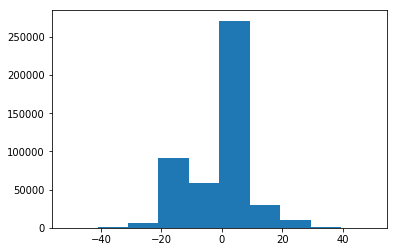

In [22]:
from sklearn.neural_network import MLPRegressor

# Establish and fit the model, with a single, 1000 perceptron layer.
#first layer will always be number of features
#hidden layer is optional
#last layer will always be number of possible outputs
 
#mlp = MLPRegressor(hidden_layer_sizes=(100,100))
#model2 = mlp.fit(x_train, y_train)

print('Training Score {}'.format(model2.score(x_train, y_train)))
print('Test Score {}'.format(model2.score(x_test, y_test)))

y_pred = model2.predict(x_test)

residuals = y_pred - y_test
plt.hist(residuals)

#### Model 3 - Gradient Boost Regressor

Training Score -0.06462351776845554
Test Score -0.06427938104513742


(array([1.30000e+02, 6.48000e+02, 7.92300e+03, 9.61670e+04, 5.38500e+04,
        2.77246e+05, 2.31530e+04, 7.03900e+03, 2.82800e+03, 3.20000e+02]),
 array([-5.00000000e+01, -4.00000531e+01, -3.00001062e+01, -2.00001594e+01,
        -1.00002125e+01, -2.65613989e-04,  9.99968126e+00,  1.99996281e+01,
         2.99995750e+01,  3.99995219e+01,  4.99994688e+01]),
 <a list of 10 Patch objects>)

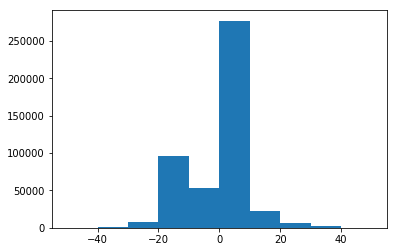

In [23]:
from sklearn import ensemble

params = {'n_estimators': 100,
          'loss': 'lad'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingRegressor(**params)
model3 = clf.fit(x_train, y_train)

print('Training Score {}'.format(model3.score(x_train, y_train)))
print('Test Score {}'.format(model3.score(x_test, y_test)))

y_pred = model3.predict(x_test)

residuals = y_pred - y_test
plt.hist(residuals)

In [24]:
# View a sample of Incorrect Predictions on the Test Set.  Mostly due to luck.

x_test['y_pred'] = y_pred
x_test['y_actual'] = y_test
x_test.loc[abs(x_test.y_pred - x_test.y_actual) > 10 ].head(10)
#x_test.drop(columns=['y_pred','y_actual'], inplace=True)

,player_start,soft_hand,dealer_showing,double_down,hit,split,y_pred,y_actual
2095713,10,0,4,0,1,0,-10.000000,10.0
1421585,18,0,9,0,1,0,-10.000000,10.0
2632561,15,0,8,0,1,0,-10.000000,10.0
385664,9,0,4,0,1,0,-10.000000,10.0
547763,18,1,4,0,1,0,-10.000000,10.0
1456502,13,0,8,0,0,0,-10.000000,10.0
1129124,11,0,3,0,1,0,-0.001161,10.0
1778014,13,0,10,0,0,0,-10.000000,10.0
769037,15,0,9,0,0,0,-10.000000,10.0
215721,9,0,10,1,1,0,-5.653020,-20.0


# Determine whether Higher Card Count improves winnings

In [23]:
#Check for nulls in the result set
series_cols = card_counting.isnull().sum(axis = 0).sort_values(ascending=False)
print(series_cols)

#card_counting[card_counting.isnull().any(axis=1)]
#card_counting.dropna(inplace=True)

total_count    0
shoe_played    0
num_lows       0
num_highs      0
player         0
hand           0
dtype: int64


/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


count_score           high           low
winnings count  392.000000  11608.000000
         mean     7.461735     -0.093901
         std     59.463704     11.943831
         min   -100.000000    -40.000000
         25%    -50.000000    -10.000000
         50%     50.000000      0.000000
         75%     50.000000     10.000000
         max    200.000000     40.000000

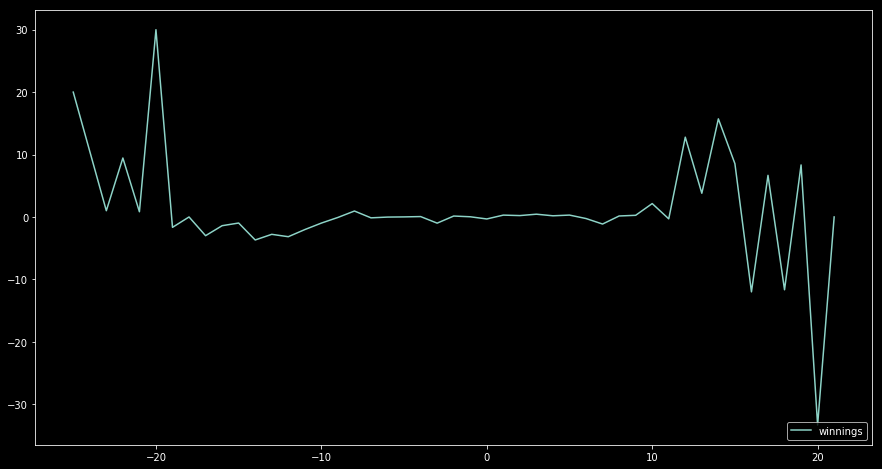

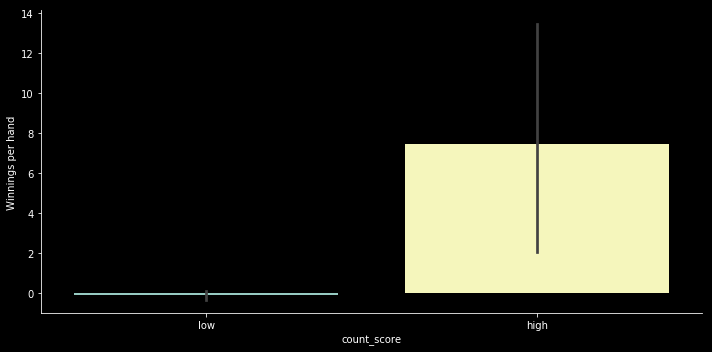

In [255]:
#---------Review the differences in results based on Card Counting ---------------

outcomes['count_score'] = np.where(outcomes.total_count < 12, 'low', 'high')
f, axes = plt.subplots(sharey=False, sharex=False , figsize=(15,8))

plt.plot(outcomes.groupby('total_count')['winnings'].mean())
#plt.plot(card_counting.loc[card_counting.shoe_played >= .4].groupby('total_count')['winnings'].mean(), label='after 50% played')
plt.legend(loc='lower right')

sns.catplot(x='count_score', y='winnings', data=outcomes, kind='bar', aspect=2 )
plt.ylabel('Winnings per hand')

counting_low_winnings = outcomes.loc[outcomes.total_count < 12, 'winnings']
counting_high_winnings = outcomes.loc[outcomes.total_count >= 12, 'winnings']

outcomes[['winnings','count_score']].groupby('count_score').describe().transpose()

-1.5399665345617302
0.12374795896531236
do not reject null (no difference)


/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


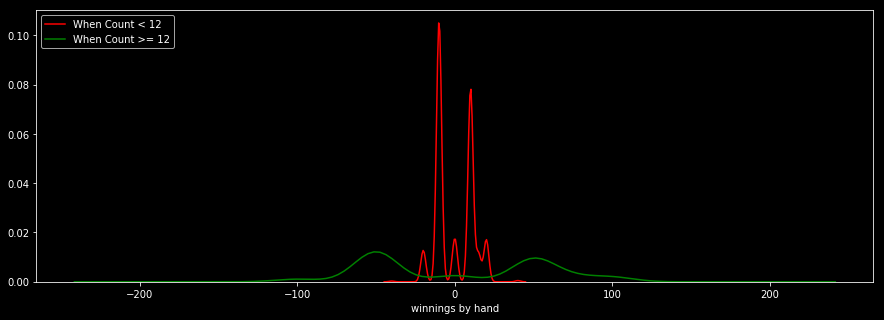

In [167]:
#T Test to verify if Card count has significant impact on outcome

#this returns a tuple (tval, pval)
import scipy.stats as stats
tval, pval = stats.ttest_ind(counting_low_winnings, counting_high_winnings, equal_var=False)  
print(tval)
print(pval)

if pval < .05:
         r = 'reject null (there is a difference)'
else:
         r = 'do not reject null (no difference)'
        
print(r)

plt.style.use('dark_background')
sns.set_style()

fig, ax = plt.subplots(figsize=(15,5))

#sns.distplot(random2_outcomes.winnings, hist=False, color='white', bins=None, label='Before Learning (Random)')
sns.distplot(counting_low_winnings, hist=False, color='red', bins=None, label='When Count < 12')
sns.distplot(counting_high_winnings, hist=False, color='green', bins=None, label='When Count >= 12')
plt.xlabel('winnings by hand')
#plt.xticks([-40,-30,-20,-10,0,10,20,30,40])
plt.legend(loc='upper left')



# Review Detailed Results from Simulation

In [256]:
#---- Review the results by starting hand and action taken ----------

pd.pivot_table(outcomes, index=['action', 'player_start'],
               values=['winnings'], aggfunc= [len,np.mean, np.sum],
              margins=True, )

len       mean      sum
                         winnings   winnings winnings
action      player_start                             
blackjack   21              543.0  18.425414  10005.0
double_down 9               260.0   1.307692    340.0
            10              462.0   2.770563   1280.0
            11              525.0   3.390476   1780.0
            13               37.0   5.945946    220.0
            14               66.0  -0.303030    -20.0
            15               48.0   1.666667     80.0
            16               36.0  -3.888889   -140.0
            17               47.0  -1.276596    -60.0
            18               54.0   4.814815    260.0
            19               33.0   9.696970    320.0
hit         4                72.0  -0.972222    -70.0
            5               142.0  -1.830986   -260.0
            6               214.0  -3.177570   -680.0
            7               312.0  -1.730769   -540.0
            8               360.0  -1.333333   -480.0
            9               154.0  -2.597403   -400.0
            10               27.0  -0.740741    -20.0
            11               38.0  -2.894737   -110.0
            12              564.0  -4.450355  -2510.0
            13              243.0  -3.415638   -830.0
            14              172.0  -4.709302   -810.0
            15              148.0  -4.121622   -610.0
            16              147.0  -6.258503   -920.0
            17               81.0  -3.209877   -260.0
split       12               83.0   6.265060    520.0
            18                6.0  20.000000    120.0
stay        12              466.0  -2.918455  -1360.0
            13              791.0  -3.678887  -2910.0
            14              819.0  -4.212454  -3450.0
            15              813.0  -4.095941  -3330.0
            16              740.0  -4.567568  -3380.0
            17              747.0  -2.971888  -2220.0
            18              779.0   0.218228    170.0
            19              703.0   4.068279   2860.0
            20             1268.0   7.294953   9250.0
All                       12000.0   0.152917   1835.0

In [42]:
#Show the number of moves that were taken in each scenario
pd.pivot_table(results[results.splittable == 0], index=['soft_hand','player_start', 'action'], 
                   columns=['dealer_showing'], values=['winnings'], aggfunc=[len])

len                              \
                                   winnings                               
dealer_showing                           2      3      4      5      6    
soft_hand player_start action                                             
0         5            hit             21.0   26.0   29.0   23.0   27.0   
          6            hit             21.0   27.0   20.0   22.0   23.0   
          7            hit             57.0   44.0   70.0   66.0   53.0   
          8            hit             60.0   64.0   66.0   46.0   62.0   
          9            double_down     86.0   81.0   90.0   74.0   84.0   
                       hit              7.0    7.0   11.0    5.0   11.0   
          10           double_down     87.0   63.0   91.0   87.0   69.0   
                       hit              7.0   15.0   10.0   11.0    6.0   
          11           double_down    111.0  116.0   93.0  113.0   92.0   
                       hit             17.0   14.0   19.0    9.0   18.0   
          12           hit              NaN    NaN    NaN    NaN    NaN   
                       stay           208.0  206.0  237.0  195.0  213.0   
          13           hit              NaN    NaN    NaN    NaN    NaN   
                       stay           193.0  191.0  221.0  205.0  215.0   
          14           hit              NaN    NaN    NaN    NaN    NaN   
                       stay           187.0  176.0  210.0  185.0  167.0   
          15           hit              NaN    NaN    NaN    NaN    NaN   
                       stay           180.0  168.0  188.0  186.0  164.0   
          16           hit              NaN    NaN    NaN    NaN    NaN   
                       stay           144.0  168.0  180.0  162.0  146.0   
          17           stay           161.0  119.0  182.0  176.0  162.0   
          18           stay           126.0  153.0  136.0  131.0  120.0   
          19           stay            95.0  119.0  118.0  120.0  111.0   
          20           stay           161.0  144.0  206.0  168.0  157.0   
          21           blackjack      113.0   99.0  130.0  107.0  110.0   
1         11           double_down     22.0   30.0   26.0   22.0   26.0   
                       hit              NaN    NaN    NaN    NaN    NaN   
          13           double_down     16.0   18.0   31.0   22.0   31.0   
                       hit              NaN    NaN    NaN    NaN    NaN   
          14           double_down     31.0   22.0   24.0   39.0   27.0   
                       hit              NaN    NaN    NaN    NaN    NaN   
          15           double_down     31.0   34.0   23.0   21.0   26.0   
                       hit              NaN    NaN    NaN    NaN    NaN   
          16           double_down     33.0   22.0   36.0   27.0   30.0   
                       hit              3.0    2.0    3.0    NaN    NaN   
                       stay             NaN    NaN    NaN    1.0    NaN   
          17           double_down     27.0   29.0   26.0   20.0   33.0   
                       hit              NaN    NaN    NaN    NaN    NaN   
                       stay             2.0    2.0    NaN    1.0    3.0   
          18           double_down     35.0    NaN   35.0   25.0   18.0   
                       stay             4.0   35.0    2.0    6.0    6.0   
          19           double_down      NaN    NaN   30.0    NaN   35.0   
                       stay            35.0   42.0    7.0   33.0    3.0   
          20           stay            22.0   30.0   27.0   33.0   19.0   

                                                                       
                                                                       
dealer_showing                         7      8      9      10     11  
soft_hand player_start action                                          
0         5            hit           34.0   26.0   29.0  137.0   32.0  
          6            hit           30.0   25.0   32.0  115.0   33.0  
       

(array([5212., 4489., 4396., 6281., 4424., 2241., 2121., 1742., 1623.,
        1083.]),
 array([17. , 17.9, 18.8, 19.7, 20.6, 21.5, 22.4, 23.3, 24.2, 25.1, 26. ]),
 <a list of 10 Patch objects>)

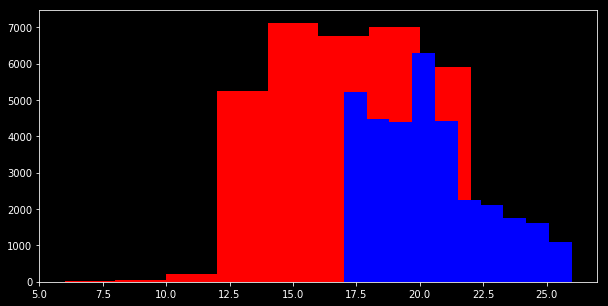

In [14]:
f, axes = plt.subplots(sharey=False, sharex=False , figsize=(10,5))
plt.hist(results_filtered.player_end_total, color='red')
plt.hist(results_filtered.dealer_end_total, color='blue')

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


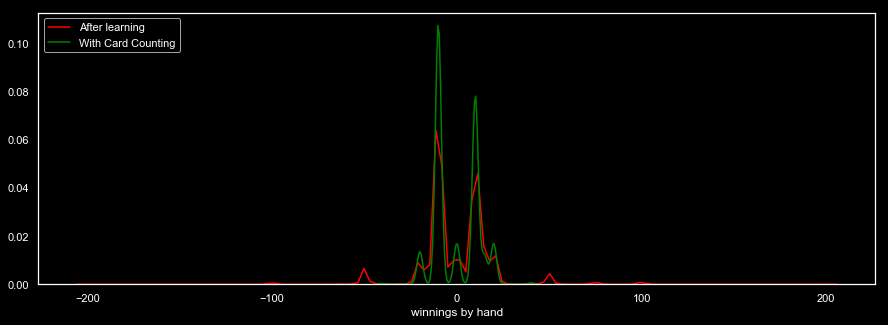

In [1137]:
plt.style.use('dark_background')
sns.set_style()

fig, ax = plt.subplots(figsize=(15,5))

#sns.distplot(random2_outcomes.winnings, hist=False, color='white', bins=None, label='Before Learning (Random)')
sns.distplot(counting_outcomes.winnings, hist=False, color='red', bins=None, label='After learning')
sns.distplot(trained_outcomes.winnings, hist=False, color='green', bins=None, label='With Card Counting')
plt.xlabel('winnings by hand')
#plt.xticks([-40,-30,-20,-10,0,10,20,30,40])
plt.legend(loc='upper left')

In [1104]:
random2_outcomes.winnings.describe()

count    6.000000e+06
mean    -2.588837e+00
std      1.141098e+01
min     -4.000000e+01
25%     -1.000000e+01
50%     -1.000000e+01
75%      1.000000e+01
max      4.000000e+01
Name: winnings, dtype: float64

In [1004]:
pd.pivot_table(random_results_filtered, index=['splittable','player_start', 'action'], 
                   columns=['dealer_showing'], values=['winnings'], aggfunc=[np.mean])

mean                                \
                                     winnings                                 
dealer_showing                             2         3         4         5    
splittable player_start action                                                
0          9            double_down  1.155174  1.264247  1.989264  2.540048   
                        hit         -2.610461 -2.527725 -2.244085 -2.060520   
           10           double_down  3.678314  4.111560  4.499963  5.170538   
                        hit         -1.974300 -1.846111 -1.531106 -1.662791   
           11           double_down  4.949626  5.261803  5.729243  6.295017   
                        hit          0.650487  0.703625  0.956187  1.025159   
           12           hit         -4.565864 -4.317146 -4.237695 -4.248185   
                        stay        -2.776987 -2.412759 -1.957399 -1.557044   
           13           double_down -0.289193 -0.171551  0.338983  1.590429   
                        hit         -4.780659 -4.672034 -4.611122 -4.437936   
                        stay        -2.844957 -2.414368 -2.044449 -1.648344   
           14           double_down  0.309735  0.878788  0.491573  1.617536   
                        hit         -5.253013 -5.133341 -4.870368 -4.903480   
                        stay        -2.831941 -2.467935 -1.980404 -1.654562   
           15           double_down -0.595745 -0.360631  0.179506  1.452928   
                        hit         -5.592637 -5.558544 -5.588370 -5.356837   
                        stay        -2.899701 -2.428997 -2.061803 -1.524502   
           16           double_down  0.303867 -0.313480  0.532586  1.938852   
                        hit         -5.959829 -5.894443 -5.807648 -5.890274   
                        stay        -2.861596 -2.389526 -1.977676 -1.676790   
           17           double_down  0.401940  0.430416  1.756659  2.604317   
                        hit         -6.265169 -6.284251 -6.286752 -6.263009   
                        stay        -1.401333 -1.060499 -0.693391 -0.446310   
           18           double_down  1.539538  2.319885  1.620499  3.622159   
                        hit         -6.811073 -6.721618 -6.680147 -6.684785   
                        stay         1.218538  1.484165  1.683667  1.983478   
           19           double_down  1.674277  2.485294  2.945302  4.126285   
                        hit         -7.306807 -7.213879 -7.256432 -7.213819   
                        stay         3.866206  4.168707  4.291412  4.370683   
           20           double_down  3.967311  3.956204  5.679012  5.379113   
...                                       ...       ...       ...       ...   
1          8            split       -5.744681 -6.302943 -4.237574 -4.333333   
           9            hit         -2.428571 -2.000000 -2.275132 -1.891892   
           10           double_down  3.578947  3.734568  4.277108  5.353846   
                        hit         -1.856287 -1.636727 -1.013917 -1.891304   
                        split       -6.343511 -6.685593 -5.602729 -5.398825   
           11           hit          0.030864 -0.261780  1.558074  0.779944   
           12           double_down  0.564263 -0.955224  1.032609  2.077151   
                        hit         -3.460366 -3.385301 -3.259318 -2.716144   
                        split        0.348793  1.070606  1.833146  2.016037   
                        stay        -2.540273 -2.253350 -1.735537 -1.403834   
           13           hit         -5.404412 -3.954248 -4.579125 -4.933921   
                        stay        -2.291667 -2.452830 -1.719298 -1.127273   
           14           hit         -5.453729 -5.526316 -5.250447 -4.830431   
                        split       -6.855019 -6.407407 -5.331255 -5.989583   
                        stay        -3.171171 -1.871560 -1.384335 -1.390977   
           15           hit         -5.081522 -5.212121 -5.343284 -4.727723   
            

In [1140]:
plt.style.use('dark_background')
sns.set_style()

fig, ax = plt.subplots(figsize=(15,5))

count    30000.000000
mean        -0.182833
std         11.854201
min        -40.000000
25%        -10.000000
50%          0.000000
75%         10.000000
max         40.000000
Name: winnings, dtype: float64

In [71]:
reporting_winning_hands = outcomes.loc[outcomes.winnings >= 0]
reporting_losing_hands = outcomes.loc[outcomes.winnings < 0]

a = reporting_winning_hands.groupby('player_start')['winnings'].sum()
b = reporting_losing_hands.groupby('player_start')['winnings'].sum()

c = reporting_winning_hands.groupby('dealer_showing')['winnings'].sum()
d = reporting_losing_hands.groupby('dealer_showing')['winnings'].sum()

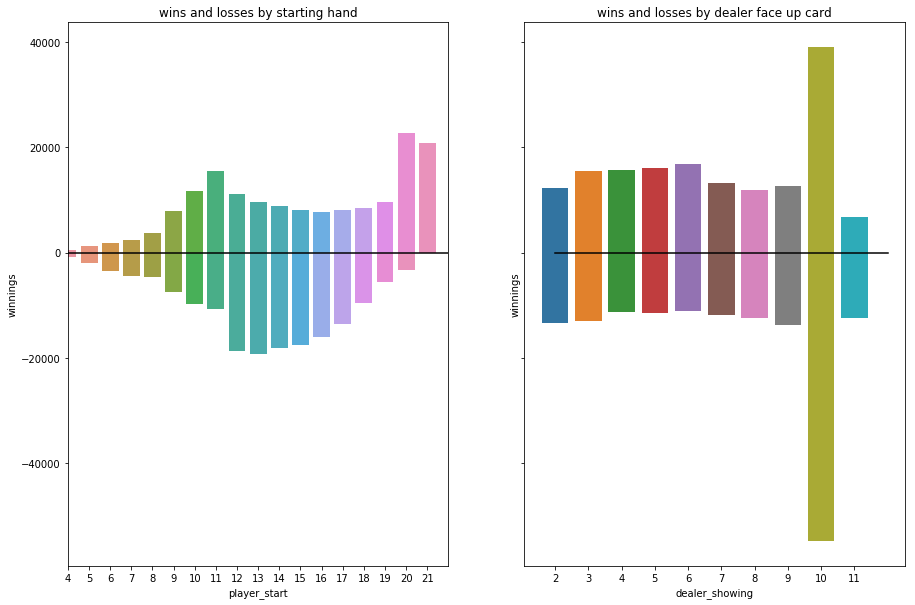

In [101]:
fig, ax = plt.subplots(1, 2, figsize=(15,10), sharey=True, sharex=False)

plt.subplot(ax[0])
sns.barplot(x=a.index, y=a, ci=None)
plt.title('wins and losses by starting hand')
sns.barplot(x=b.index, y=b, ci=None)
sns.lineplot(x=[0,21], y=[0,0], color='black')
plt.xlim(0,18)
plt.xticks(range(0,18), a.index)

plt.subplot(ax[1])
sns.barplot(x=c.index, y=c, ci=None)
plt.title('wins and losses by dealer face up card')
sns.barplot(x=d.index, y=d, ci=None)
sns.lineplot(x=[0,10], y=[0,0], color='black')

In [67]:
reporting = outcomes.copy()
d = pd.get_dummies(reporting.win)

reporting.drop(columns=['win','count_score'], inplace=True)
reporting = pd.concat([reporting, d], axis=1)


reporting = pd.pivot_table(reporting, index=['player_start', 'dealer_showing'], values=['lose','push','win','winnings'],
              aggfunc=[np.sum])

reporting = pd.DataFrame(reporting.to_records())

reporting.columns = ['player_start','dealer_showing','lose','push','win','winnings']
reporting['hands'] = reporting.win + reporting.lose + reporting.push
reporting['avg_win'] = round(reporting.winnings / reporting.hands,2)
reporting

,player_start,dealer_showing,lose,push,win,winnings,hands,avg_win
0,4,2,10.0,0.0,6.0,-40.0,16.0,-2.50
1,4,3,9.0,1.0,8.0,-10.0,18.0,-0.56
2,4,4,5.0,1.0,2.0,-30.0,8.0,-3.75
3,4,5,4.0,0.0,5.0,10.0,9.0,1.11
4,4,6,3.0,0.0,3.0,0.0,6.0,0.00
5,4,7,5.0,1.0,9.0,40.0,15.0,2.67
6,4,8,9.0,1.0,5.0,-40.0,15.0,-2.67
7,4,9,5.0,2.0,2.0,-30.0,9.0,-3.33
8,4,10,34.0,2.0,12.0,-220.0,48.0,-4.58
9,4,11,6.0,2.0,2.0,-40.0,10.0,-4.00


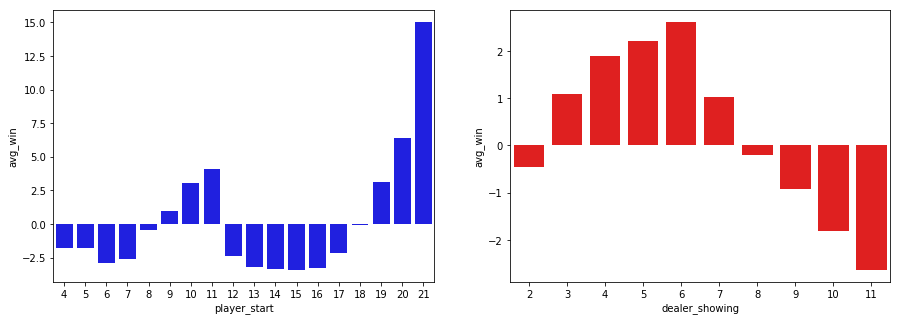

In [103]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

plt.subplot(ax[0])
sns.barplot(reporting.player_start, reporting['avg_win'],  ci=None, color='blue')

plt.subplot(ax[1])
sns.barplot(reporting.dealer_showing, reporting['avg_win'],  ci=None, color='red')

Text(0.5,60,'dealer showing')

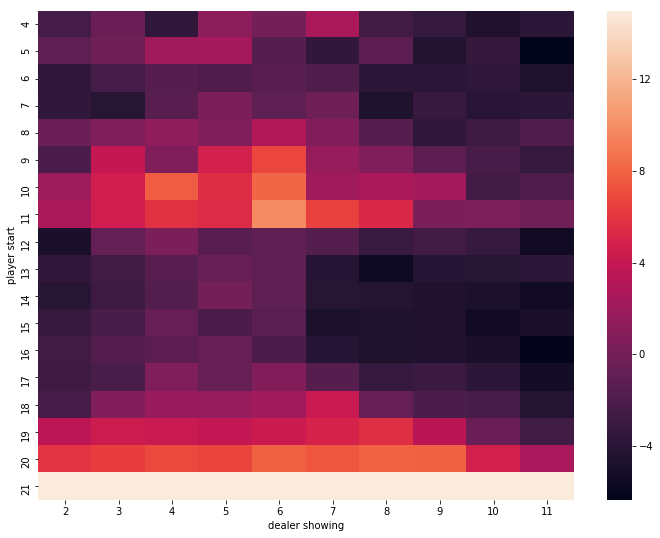

In [102]:
hm = reporting.copy()
d = pd.get_dummies(hm.dealer_showing)

hm = pd.concat([hm,d], axis=1)

for col in range(2,12):
    hm[col] = hm[col] * hm.avg_win

#hm.index = hm.player_start
hm.drop(columns=['lose','push','win', 'winnings', 'avg_win', 'dealer_showing'], inplace=True)

hm = hm.groupby('player_start').sum()

hm = pd.DataFrame(hm.to_records())

hm.index = hm.player_start

hm.drop(columns=['hands','player_start'], inplace=True)

hm

f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(hm)
plt.ylabel('player start')
plt.xlabel('dealer showing')

# Test Model - by exploring Individual Scenarios

In [ ]:
#player_start	soft_hand	dealer_showing	double_down	hit	split

scenario_hit = np.array([16,0,6,0,1,0]).reshape(1,-1)
scenario_stay = np.array([16,0,6,0,0,0]).reshape(1,-1)
scenario_split = np.array([16,0,6,0,0,1]).reshape(1,-1)
scenario_double = np.array([16,0,6,1,1,0]).reshape(1,-1)

prediction_hit = model.predict(scenario_hit)
prediction_stay = model.predict(scenario_stay)
prediction_split = model.predict(scenario_split)
prediction_double = model.predict(scenario_double)

bet = 10

print(prediction_hit)
# prob_win_hit = model.predict_proba(scenario_hit)[0][1]
# print('Probability of winning if hit is {}'.format(prediction_hit[0][1]))

print(prediction_stay)
# prob_win_stay = model.predict_proba(scenario_stay)[0][1]
# print('Probability of winning if stay is {}'.format(prediction_stay[0][1]))

print(prediction_split)
# prob_win_split = model.predict_proba(scenario_split)[0][1]
# print('Probability of winning if split is {}'.format(prediction_split[0][1]))

print(prediction_double)
# prob_win_double = model.predict_proba(scenario_double)[0][1]
# print('Probability of winning if double is {}'.format(prediction_double[0][1]))

#calculate expected value
# eva_hit = round((bet * prob_win_hit) - (bet * (1-prob_win_hit)),2)
# eva_stay = round((bet * prob_win_stay) - (bet * (1-prob_win_stay)),2)
# eva_split = round((2 * bet * prob_win_split) - (2 * bet * (1-prob_win_split)),2)
# eva_double = round((2 * bet * prob_win_double) - (2 * bet * (1-prob_win_double)),2)

# print(eva_hit)
# print(eva_stay)
# print(eva_split)
# print(eva_double)



# Test Model - by simulating Individual Scenarios

In [178]:
def play_new_hand(bet, shoe):
    
    card1 = shoe.pop()
    card2 = shoe.pop()
    dealer_card1 = shoe.pop()
    dealer_showing = get_value(dealer_card1)
    
    print(card1)
    print(card2)
    print('Dealer Showing: {}\n'.format(dealer_card1))
    v1 = get_value(card1)
    v2 = get_value(card2)
    on_first_move = True
    
    #If both cards are aces, set values of one to 1
    if (v1 == 11) & (v2 == 11):
        v1 = 1
          
    #check to see if Ace in either of the original 2 cards dealt.  If so label as soft hand.
    if (v1 == 11) | (v2 == 11):
        soft_hand = 1  
    else:
        soft_hand = 0   
  
    #If both cards are same value, mark as splittable
    if get_face(card1) == get_face(card2):
        splittable = 1
    else:
        splittable = 0
          
    player_total = v1 + v2

    #determine if doubleable
    if (on_first_move == True) & (player_total in (9,10,11)):
        doubleable = 1
    else:
        doubleable = 0
    
    if player_total == 21:
        print('Blackjack!')  
    elif player_total < 9:
        print('Standard move is to hit')
    else:
        rec = get_recommended_move(model, bet, player_total, soft_hand, dealer_showing, splittable, doubleable)
        print('Recommended move is to ' + rec)


        
shoe = shuffle_deck(6)    
play_new_hand(10, shoe) 


3 Diamonds
3 Hearts
Dealer Showing: King Spades

Standard move is to hit
